In [10]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import numpy as np

import os

In [11]:
def build_corpus(folder_path: str) -> list:
    """
    Given a directory of text files, builds a corpus of
    sentences that can be used to train neural networks.
    """
    corpus = []

    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith(".txt"):
                full_path_to_file = root + "/" + filename
                with open(full_path_to_file, 'r') as infile:
                    lines = infile.read().split('\n')
                    corpus += lines
    
    # deduplicating because I'm getting weird prediction results
    corpus = list(set(corpus))

    return corpus

In [12]:
corpus = build_corpus("./corpus")

In [13]:
# no need for an OOV token, since we'll be training using the entire corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
total_words = len(word_index) + 1

In [14]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [15]:
len(input_sequences)

6263

In [16]:
xs = input_sequences[:,:-1]
labels = input_sequences[:, -1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [17]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(xs, ys, epochs=100, verbose=1)
#print model.summary()
print(model)

2021-11-21 09:58:22.971052: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-21 09:58:22.971422: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


Train on 6263 samples
Epoch 1/100


2021-11-21 09:58:26.600120: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_4483_4667' and '__inference___backward_standard_lstm_5328_5815_specialized_for_StatefulPartitionedCall_1_at___inference_distributed_function_5972' both implement 'lstm_b35d9826-a8d8-4699-a95a-a9533edfbdd6' but their signatures do not match.


6263/6263 [==============================] - 17s 3ms/sample - loss: 6.1988 - accuracy: 0.0433
Epoch 2/100
6263/6263 [==============================] - 13s 2ms/sample - loss: 5.2718 - accuracy: 0.1071
Epoch 3/100
6263/6263 [==============================] - 13s 2ms/sample - loss: 4.3688 - accuracy: 0.1852
Epoch 4/100
6263/6263 [==============================] - 13s 2ms/sample - loss: 3.3837 - accuracy: 0.2762
Epoch 5/100
6263/6263 [==============================] - 12s 2ms/sample - loss: 2.5304 - accuracy: 0.4164
Epoch 6/100
6263/6263 [==============================] - 12s 2ms/sample - loss: 1.8792 - accuracy: 0.5459
Epoch 7/100
6263/6263 [==============================] - 13s 2ms/sample - loss: 1.4590 - accuracy: 0.6417
Epoch 8/100
6263/6263 [==============================] - 14s 2ms/sample - loss: 1.1720 - accuracy: 0.7128
Epoch 9/100
6263/6263 [==============================] - 19s 3ms/sample - loss: 1.0112 - accuracy: 0.7468
Epoch 10/100
6263/6263 [==============================] - 

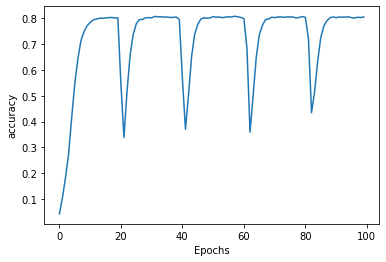

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

In [24]:
seed_text = "All I can say is"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	# predicted = model.predict_classes(token_list, verbose=0)
	predict_x=model.predict(token_list) 
	classes_x=np.argmax(predict_x,axis=1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == classes_x:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

All I can say is so bold it her to the stars above let her go god bless her all before love please the brain open night women's to you the day off and try to repair you girl an pretty bad till the sun you ever feels i got mud on my shoes all as we were have better blood cause i come home and rescue you standing here with the holy ghost go of this plan wide everything i love you almost dropped me so maybe i five six seven or think should i lay on her now my pocket change your day


Dead leaves and the dirty ground and laying \
nobody's praying \
oh oh oh oh oh \
name only make a lot of money \
around books new around \
six crap shootin' pallbearers \
in my hand again \
this much written \
make hold money of girls \
he don't forget it \
inside sky these adore that you're \
somebody calls out for another plate of food \
your english lovin' thoughts important \
come off and least that hi \
some on the couch girl \
isn't that when she finds \
all as someone left is fleeting \
they in i look it  \
the newspaper or choose that \
i love jack white like a toothache baby  \
little

#### I Love Jack White Like A Toothache, Baby
##### An exploration of text generation using recurrant neural networks